## Why to Read this Tutorial?
* In this tutorial, you will learn about _clustering_ (or cluster analysis). Clustering means to group a set of elements that have similar properties. In other words, clustering forms groups of elements that are more similar to each other than to all elements in the other groups. These groups are typically called _clusters_. This tutorial will introduce and illustrate the very basics of clustering.
* The clustering algorithm used is called $k$-means and is used to discover $k$ clusters in your data while you are free to choose $k$.
* Furthermore, an algorithm for topic detection within a text corpus will be presented.
* You might want to read [NaiveBayes.ipynb](NaiveBayes.ipynb) first as it introduces some vector space model-related concepts that will be used in this tutorial.
* At the end of this tutorial, you will be able to cluster arbitrary input data (although the tutorial will use text). Additionally, you will be able to detect topics within a text corpus.



### Preparation

The following code snippet initializes your Python run-time enviroment in order to run all of the subsequent actions.

In [62]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
import sklearn
from time import time
#import nltk
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

Again, we start with reading our data.

In [63]:
# reads the CSV using the pandas Python package, this creates a variable called "df" that will store the
# CSV contents in form of a table, the so-called data frame
df=pd.read_csv("./critics.csv")
# let's drop rows with missing publication, store the results in a variable called "df2"
df2=df[df.publication.notnull()]
# ... and display the first 5 rows of the table, the argument within the paratheses tells you how many rows will be read
df2.head(5)

critic  fresh    imdb           publication                                              quote review_date  rtid      title
0  Owen Gleiberman  fresh  114709  Entertainment Weekly                                                NaN  2011-09-07  9559  Toy story
1      Derek Adams  fresh  114709              Time Out  So ingenious in concept, design and execution ...  2009-10-04  9559  Toy story
2  Richard Corliss  fresh  114709         TIME Magazine                  The year's most inventive comedy.  2008-08-31  9559  Toy story
3      David Ansen  fresh  114709              Newsweek  A winning animated feature that has something ...  2008-08-18  9559  Toy story
4    Leonard Klady  fresh  114709               Variety  The film sports a provocative and appealing st...  2008-06-09  9559  Toy story

The [_data frame_](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) is one of the central objects you will be working with. For instance, it features the _head()_ method for inspecting the first rows of the data frame or the _shape_ attribute which shows you its actual dimensions.

Amongst others, data frames can also be sorted using the _sort()_ method. However, sorting should only be carried out when it is really needed as it may take a long time. A general rule of thumb is that you should sort your data frame in the last possible moment, e.g., directly before you display its contents.

In [64]:
# display the data frame's dimensions: 27631 rows and 8 columns
dimensions=df2.shape
print "Rows: "+str(dimensions[0]) 
# Python does not allow you to concatenate strings and integers directly hence the str() that casts any object into a string
print "Columns: "+str(dimensions[1]) 

df2=df2.sort(['imdb'])
df2.head()

Rows: 27631
Columns: 8


critic fresh   imdb     publication quote review_date       rtid          title
26745  Derek Adams  none  11652        Time Out   NaN  2006-06-24  575684525    The Saphead
26746          NaN  none  11652  New York Times   NaN  2006-03-25  575684525    The Saphead
21470          NaN  none  13140         Variety   NaN  2008-10-16      22731  Foolish Wives
21471          NaN  none  13140  New York Times   NaN  2006-03-25      22731  Foolish Wives
21472          NaN  none  13140        Time Out   NaN  2006-01-26      22731  Foolish Wives

## Analysing Texts and Representing them in the Vector Space Model

Typically, text is represented in the vector space model (VSM) that has been introduced [in another tutorial](NaiveBayes.ipynb). In this tutorial, we will use the [_TfidfVectorizer_](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) instead of the [_CountVectorizer_](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) used before to represent our documents in the VSM.

Furthermore, we make use of a technique called [_stop word elimination_](https://en.wikipedia.org/wiki/Stop_words).
Roughly speaking, stop words are filtered out from texts in a natural language before further processing because they do not contribute much to the semantics of a certain text.
Typically, stop words are the most commonly used terms in the natural language, i.e., they differ per language.
As stop word elimination limits the number of index terms, it can increase performance of retrieval but at the same time it may also have specific downsides depending on the retrieval scenario. For instance, imagine a music retrieval system. If you remove the term "the" from the index terms, you will no longer be able to search for compound terms such as "The Cure" or the like.

In [65]:
#http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
#http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
# we will now drop all lines without a quote (if there are any)
df2=df2[df2.quote.notnull()]
#df2.head()
corpus=df2.quote
Xtfidf=tfidfvectorizer.fit_transform(corpus)
wordstfidf=tfidfvectorizer.get_feature_names()
tfidfvectorizer = TfidfVectorizer(min_df=2, max_df=0.5, max_features=50000, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(corpus)
#wordstfidf

## Cluster Analysis

Representing documents in the VSM is the first towards the utilization of methods from machine learning (ML). As a result from running the cells above, we yield VSM representations from the input documents. In other words, we obtain a lot of different vectors embedded into a vector space.
The representation of data as vectors is especially handy if you want to apply methods from ML because ML assumes quite often that you work within a vector space. For instance, you can easily compute how distant two vectors are using the Euclidean distance (or other [distance measures](https://en.wikipedia.org/wiki/Distance)) within a vector space:

$$ \delta_{Euclid}(q,p)=\sqrt{\sum_{i=1}^n (q_i-p_i)^2},$$

where $q$ and $p$ are the vectors whose distance you are interested in. The index $i$ indicates each component of the vectors. Calculating the distance between two vectors can be helpful to determine how similar two documents are.

The utility of the vector space representation becomes most obvious with the help of an example and some test data that we will create next. To facilitate understanding, we will work in a two-dimensional vector space.

In [66]:
# create sample data
d = {'obs01': (1,2), 'obs02': (10,10),'obs03':(60,40),'obs04':(100,80),'obs05':(99,81),'obs06':(1,1),'obs07':(45,55),'obs08':(9,10),'obs09':(11,11),'obs10':(1,11)}
# create a data frame from our sample data
sampleDF=pd.DataFrame(data=d)
# transpose the data frame for later use
sampleDF=sampleDF.transpose()
sampleDF.head(10)

0   1
obs01    1   2
obs02   10  10
obs03   60  40
obs04  100  80
obs05   99  81
obs06    1   1
obs07   45  55
obs08    9  10
obs09   11  11
obs10    1  11

The sample data contains 10 observations, one per row, and an $x$ and $y$ coordinate found in columns $0$ and $1$. This data can be easily plotted to visualize its distribution. In this example, we use a scatter plot that is also offered by the _DataFrame_ object of _pandas_, the Python data analysis library. Other kinds of plots can be found in the [documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) of the _plot()_ method.

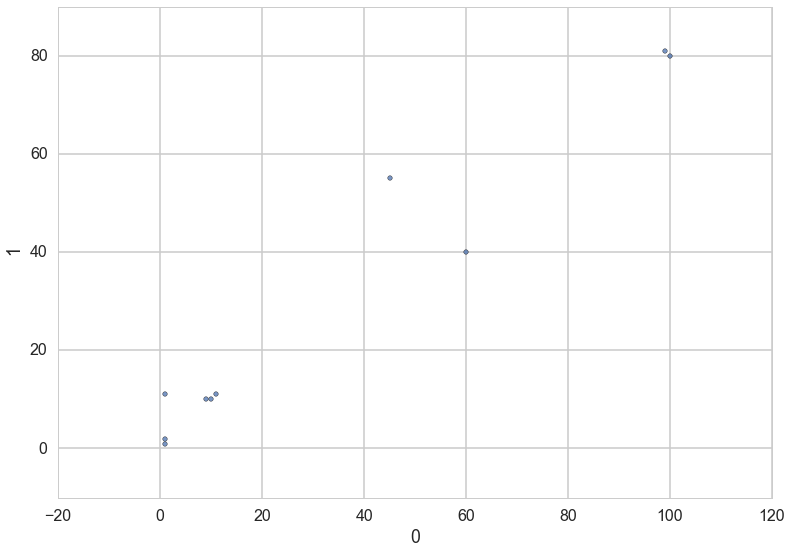

In [67]:
# plot the sample data
sampleDF.plot(x=0,y=1,kind='scatter',alpha=0.75) # we have to define explicitly which data is used for the x and y axes

The data is obviously separated into 3 distant clusters. But imagine a more complex data set with more dimensions than 2 as it is the case with textual data. In this case, it will not be easy to determine the clusters. This motivates the usage of cluster analysis algorithms which you will feed with your data and they will return the clusters present in your data.

### The $k$-means Algorithm

The [$k$-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) is a widely used algorithm for cluster analysis. The algorithm tries to partition the observation you have into $k$ different clusters. Please note that you have to define $k$ before running the algorithm.

In [68]:
# import the k-means algorithm
from sklearn.cluster import KMeans
# define the number of clusters to be found
true_k=3
# initialize the k-means algorithm
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# apply the algorithm on the data
km.fit(sampleDF)
# add the detected clusters as a new column to the original data frame
sampleDF['cluster']=km.labels_
sampleDF=sampleDF.sort('cluster')
sampleDF.head(10)

0   1  cluster
obs03   60  40        0
obs07   45  55        0
obs01    1   2        1
obs02   10  10        1
obs06    1   1        1
obs08    9  10        1
obs09   11  11        1
obs10    1  11        1
obs04  100  80        2
obs05   99  81        2

From inspecting the table, we already see that 3 clusters have been found and how the data is associated with them. Everything worked as expected.
We can further inspect the clusters' centroid, i.e., the hypothetical object that lie in the center of the discovered clusters.

In [69]:
clusterCenters=pd.DataFrame(data=km.cluster_centers_)
clusterCenters.head()

0     1
0  52.5  47.5
1   5.5   7.5
2  99.5  80.5

We can also visualize the centroids (drawn in red) in combination with the scatter plot of the sample data.

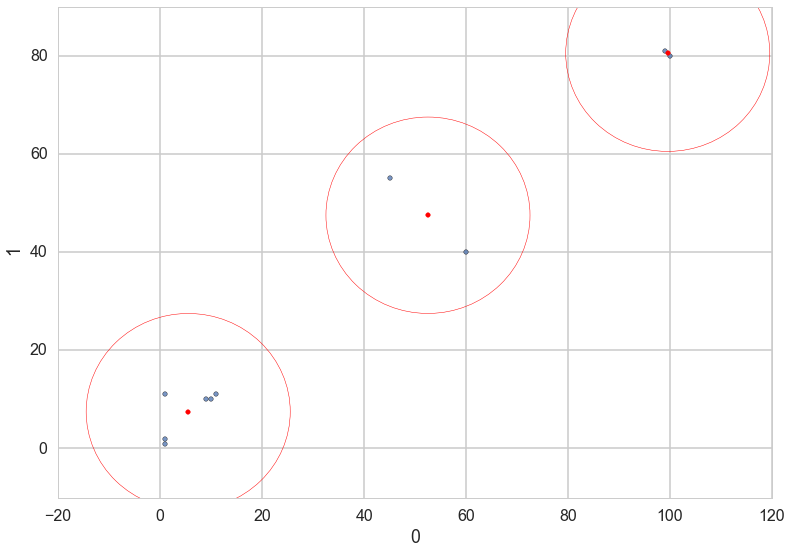

In [70]:
# plot the sample data and save the plot in the variable "ax"
ax=sampleDF.plot(x=0,y=1,kind='scatter',alpha=0.75)
# plot the centroids in red
plt.scatter(x=clusterCenters[0],y=clusterCenters[1],color='red')
# next, define the circles' centers surrounding the clusters for a better visualization result
cirlePos1=(clusterCenters[0][0],clusterCenters[1][0])
cirlePos2=(clusterCenters[0][1],clusterCenters[1][1])
cirlePos3=(clusterCenters[0][2],clusterCenters[1][2])
# create the unfilled circles with a radius of 20 (this value is arbitrary)
circ1=plt.Circle(cirlePos1,20,color='r',fill=False)
circ2=plt.Circle(cirlePos2,20,color='r',fill=False)
circ3=plt.Circle(cirlePos3,20,color='r',fill=False)
# add the circles to your plot
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)

### Working with Real Data

Next, we are using $k$-means with our real data, i.e., the contents of the quotes. What we are trying to find out are the most similar quotes (whatever this means) to each other. A sample use case could be a quote recommendation service that takes a quote and returns all quotes from the same cluster. For educational reasons, we are trying to cluster our data in 10 different clusters.

To inspect the results, we will use the [_describe()_](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) method of the DataFrame object as it will print some commonly used descriptive statistics of the analysed data.

In [71]:
true_k=10
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# fit the k-means algorithm on the data created above
km.fit(Xtfidf)
# add the detected clusters as a new column to the original data frame
df2['cluster']=km.labels_
# group the data by the cluster and describe it
df2.groupby('cluster').describe()

imdb          rtid
cluster                                    
0       count     1678.000000  1.678000e+03
        mean    162540.507151  7.193157e+07
        std     173292.544698  2.039235e+08
        min      13442.000000  1.100000e+01
        25%      97670.750000  1.142500e+04
        50%     116232.500000  1.351900e+04
        75%     134789.750000  1.687625e+04
        max    1186367.000000  7.709273e+08
1       count      305.000000  3.050000e+02
        mean    165855.019672  7.380015e+07
        std     170748.051634  1.986861e+08
        min      13442.000000  2.100000e+01
        25%      79714.000000  1.205200e+04
        50%     110475.000000  1.369200e+04
        75%     162661.000000  1.721700e+04
        max    1190539.000000  7.708023e+08
2       count     7478.000000  7.478000e+03
        mean    155174.212757  5.396261e+07
        std     151764.599913  1.789374e+08
        min      13442.000000  1.100000e+01
        25%     101556.250000  1.129200e+04
        50%     116999.000000  1.333000e+04
        75%     139134.000000  1.624800e+04
        max    1190539.000000  7.708206e+08
3       count     1676.000000  1.676000e+03
        mean    142084.009547  5.539673e+07
        std     146807.608842  1.815422e+08
        min      13442.000000  1.100000e+01
        25%      88157.250000  1.149175e+04
        50%     112495.000000  1.346650e+04
...                       ...           ...
6       std     191791.612975  2.016933e+08
        min      17925.000000  1.100000e+01
        25%      92991.000000  1.124025e+04
        50%     115681.500000  1.321550e+04
        75%     144715.000000  1.669925e+04
        max    1186367.000000  7.707976e+08
7       count      517.000000  5.170000e+02
        mean    156789.764023  5.540864e+07
        std     165072.240125  1.797437e+08
        min      21749.000000  1.200000e+01
        25%      94336.000000  1.151900e+04
        50%     113305.000000  1.340800e+04
        75%     126250.000000  1.639400e+04
        max    1099212.000000  7.708035e+08
8       count      331.000000  3.310000e+02
        mean    152889.643505  7.135588e+07
        std     154623.305994  2.058566e+08
        min      13442.000000  1.100000e+01
        25%      89269.500000  1.117000e+04
        50%     113189.000000  1.341700e+04
        75%     133588.500000  1.700250e+04
        max    1045655.000000  7.710318e+08
9       count     1621.000000  1.621000e+03
        mean    169384.834053  5.565154e+07
        std     177994.246487  1.807566e+08
        min      17136.000000  1.100000e+01
        25%     105156.000000  1.130600e+04
        50%     116985.000000  1.332200e+04
        75%     144168.000000  1.630300e+04
        max    1186367.000000  7.708206e+08

[80 rows x 2 columns]

As you can conclude from the _count_ rows above, our clusters are getting fairly large and probably not very meaningful regarding their contents. This is due to the fact that our data frame is large and we want to "squeeze" it into 10 clusters or categories. 

Consider the following example. You have summaries of all books you have read in your life and your task is to summarize all these summaries using only 3 words. Will this yield meaningful results?

In [72]:
# inspect the dimensions of the data frame
df2.shape

(15561, 9)

Hence, we run the $k$-means algorithm again using a cluster amountof 10% regarding the total amount of reviews. Then, we will inspect the outcome as done above. The choice of 10% is rather arbitrary but you can read a lot about choosing $k$ right [here](https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/).

Please note that this step might take __several minutes__ depending on your computer.

In [73]:
t0 = time()
true_k=1500
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
km.fit(Xtfidf)
learningTime=(time() - t0)
df2['cluster']=km.labels_
df2.groupby('cluster').describe()

imdb          rtid
cluster                                   
0       count       1.000000      1.000000
        mean   109813.000000  12326.000000
        std              NaN           NaN
        min    109813.000000  12326.000000
        25%    109813.000000  12326.000000
        50%    109813.000000  12326.000000
        75%    109813.000000  12326.000000
        max    109813.000000  12326.000000
1       count       1.000000      1.000000
        mean    65063.000000  16258.000000
        std              NaN           NaN
        min     65063.000000  16258.000000
        25%     65063.000000  16258.000000
        50%     65063.000000  16258.000000
        75%     65063.000000  16258.000000
        max     65063.000000  16258.000000
2       count       1.000000      1.000000
        mean   137338.000000  14561.000000
        std              NaN           NaN
        min    137338.000000  14561.000000
        25%    137338.000000  14561.000000
        50%    137338.000000  14561.000000
        75%    137338.000000  14561.000000
        max    137338.000000  14561.000000
3       count       1.000000      1.000000
        mean   111503.000000  16394.000000
        std              NaN           NaN
        min    111503.000000  16394.000000
        25%    111503.000000  16394.000000
        50%    111503.000000  16394.000000
...                      ...           ...
1496    std              NaN           NaN
        min     93779.000000  12686.000000
        25%     93779.000000  12686.000000
        50%     93779.000000  12686.000000
        75%     93779.000000  12686.000000
        max     93779.000000  12686.000000
1497    count       1.000000      1.000000
        mean   115744.000000  13333.000000
        std              NaN           NaN
        min    115744.000000  13333.000000
        25%    115744.000000  13333.000000
        50%    115744.000000  13333.000000
        75%    115744.000000  13333.000000
        max    115744.000000  13333.000000
1498    count       2.000000      2.000000
        mean   112663.000000  13480.000000
        std       284.256926   3261.176475
        min    112462.000000  11174.000000
        25%    112562.500000  12327.000000
        50%    112663.000000  13480.000000
        75%    112763.500000  14633.000000
        max    112864.000000  15786.000000
1499    count       1.000000      1.000000
        mean   117364.000000  12501.000000
        std              NaN           NaN
        min    117364.000000  12501.000000
        25%    117364.000000  12501.000000
        50%    117364.000000  12501.000000
        75%    117364.000000  12501.000000
        max    117364.000000  12501.000000

[12000 rows x 2 columns]

In [74]:
print("Learning was done in %0.3fs." % learningTime)

Learning was done in 129.339s.


Next, we will sort our data frame with respect to the cluster ID and display the first 100 rows. You will see that the quotes in the same cluster are similar to each other with respect to their choice of words. The results are not perfect as $tf*idf$ does not deal with the semantics of terms. 

In [75]:
df2=df2.sort("cluster")
df2.head(100)

critic   fresh    imdb              publication                                              quote review_date       rtid                               title  cluster
3732                 Lucy Mohl  rotten  109813                 Film.com                        It's a dull day in Bedrock.  2000-01-01      12326                     The Flintstones        0
16615              Roger Ebert  rotten   65063        Chicago Sun-Times  Woody Allen's Take the Money and Run has some ...  2004-10-23      16258              Take the Money and Run        1
20753  Mary Elizabeth Williams  rotten  137338                Salon.com  Though it has its moments, 200 Cigarettes fail...  2000-01-01      14561                      200 Cigarettes        2
3990        James Berardinelli   fresh  111503                ReelViews  An old-fashioned, high-tech, fun time at the m...  2000-01-01      16394                           True Lies        3
18994          Moira MacDonald  rotten  985699            Seattle Times  You just can't quite enter the world of this f...  2008-12-29  770671940                            Valkyrie        4
1128                Mike Clark   fresh  113247                USA Today  Writer-director Mathieu Kassovitz mines so muc...  2000-01-01   98832611                            La haine        5
12349               Joe Leydon  rotten  120389                  Variety  Like the TV series, the pic features makeup an...  2008-05-14      12077        Turbo: A Power Rangers Movie        6
24608            Eric Harrison   fresh  332047        Houston Chronicle  At the movie's core is a question that all cou...  2005-04-08         23                         Fever Pitch        7
395                Jeff Millar   fresh  112682        Houston Chronicle  The City of Lost Children is a series of assoc...  2000-01-01      13050          La cité des enfants perdus        8
5035               Brian Lowry   fresh  107614                  Variety  Although overly sappy in places and probably 2...  2008-07-22      10997                      Mrs. Doubtfire        9
24522              Ruthe Stein  rotten  119256  San Francisco Chronicle  Noirish thrillers live or die by their plot tw...  2000-01-01      14170                              Sydney       10
26783             Lou Lumenick   fresh  141399            New York Post                      Amusing, light entertainment.  2000-01-01      15866                     Isn't She Great       11
10252             Keith Uhlich   fresh   81398        Time Out New York  When has a performer as fully and uniquely sac...  2010-11-03      15121                         Raging Bull       12
17931             Geoff Andrew   fresh   58329                 Time Out  It's still thrilling to watch, lush, cool and ...  2006-02-09      10595                              Marnie       12
17986                      NaN   fresh  123324                USA Today             Entertaining and nostalgically moving!  2000-01-01      14374           Why Do Fools Fall in Love       12
19415          Owen Gleiberman   fresh  140888     Entertainment Weekly             A richly tender and moving experience.  2000-01-01      14037                   Central do Brasil       12
11954              Roger Ebert   fresh  116754        Chicago Sun-Times            A thoughtful and moving film about war.  2000-01-01      14448                  Kavkazskiy plennik       12
4230              Geoff Andrew   fresh  106226                 Time Out            Scorsese's most poignantly moving film.  2006-02-09      10537                The Age of Innocence       12
16383             Mick LaSalle  rotten  166813  San Francisco Chronicle  A mishmash that is sometimes moving, sometimes...  2002-05-24       9502    Spirit: Stallion of the Cimarron       12
356               Kevin Thomas   fresh  114057        Los Angeles Times  Parker has shown how involving and moving Shak...  2001-02-13      13094                             Othello       12
11318        

## Text Analysis with the Non-Negative matrix factorization by Projected Gradient (NMF)

Well, things are getting a little bit more mathematically challenging from here but there is a good overview over at [Wikipedia](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization). The actual implementation is described [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html).

For an understanding of the following code, we will try to outline the idea behind NMF - or more precise - what it is used for in this tutorial. Bascially, we want to find out which topics are "hidden" in our quotes. The output of the NMF algorithm will be a list of the discovered topics where each topic is represented by a set of unique terms.

Depending on the number of topics, the learning will take a while.

In [76]:
# import the NMF algorithm
from sklearn.decomposition import NMF
# set a number of topics to be learnt
n_topics=10
# use NMF with our data
nmf = NMF(n_components=n_topics, random_state=1).fit(Xtfidf)

In [79]:
# for clarity, we restrict the displayed number of topic-specif terms
n_top_words = 20
# get the feature names (as above)
feature_names = tfidfvectorizer.get_feature_names()
# iterate of all topics found by the NMF algorithm
for topic_idx, topic in enumerate(nmf.components_):
    print("* * * * * * * * * * * * * * * *")
    print("Topic #%d: (first #%d terms)" % (topic_idx, n_top_words))
    topic_idxs=topic.argsort()[:-n_top_words - 1:-1] # sort the entries of "topic" by size
    
    # the next line is pretty compact, for an illustration what is happening see below
    # take all entries from "feature_names" that are found in "topic_idxs" and join them in a string separated by " "
    print(" ".join([feature_names[i] for i in topic_idxs])) 
    
    # to understand the line above you might want to uncomment the 3 lines below
    #print "\nSample of the expansion happening above:"
    #print topic_idxs # prints all topic index of the current topic
    #print feature_names[topic_idxs[0]] # displays the name of the term addressed at the first element of "topic_idxs"
    

* * * * * * * * * * * * * * * *
Topic #0: (first #20 terms)
movie great kind enjoyable isn moments bad lot horror makes funniest big going summer year little end kids think tv
* * * * * * * * * * * * * * * *
Topic #1: (first #20 terms)
film great new horror finest moving real beautiful fine emotional war deeply american fascinating noir moments end people family rare
* * * * * * * * * * * * * * * *
Topic #2: (first #20 terms)
good bad pretty natured isn feel performances acting hearted looking time makes better stuff direction idea writing looks example going
* * * * * * * * * * * * * * * *
Topic #3: (first #20 terms)
comedy romantic laughs romance black adventure drama charming screwball melodrama high spirited light bright thriller satire likable teen uneven action
* * * * * * * * * * * * * * * *
Topic #4: (first #20 terms)
like movies feels ve plays seen looks watching bad feel just sounds look tv makes don ll life know little
* * * * * * * * * * * * * * * *
Topic #5: (first #20 ter

## What to Do Next?

* You might want to apply [_stemming_](https://en.wikipedia.org/wiki/Stemming) in combination with stop world elimnation on your natural language texts. Stemming reduces words to a (sometimes) artifical base form, e.g., the terms "houses", "housing" and "house" will be reduced to "house" as they are related to the same semantic concept. This might improve the quality of your topic analysis as these 3 terms will end up in the same topic. Without stemming, the terms can occur in different topic what is not what you would expect from a topic analysis. Adding stemming to the tutorial above is a little difficult as it is not directly supported by the _scikit learn_ package but there is an [article](http://scikit-learn.org/stable/modules/feature_extraction.html) to get you started using [_NLTK_](http://www.nltk.org/book/), a natural language processing toolkit for Python.
* The [data science lab](https://datasciencelab.wordpress.com/) does also provide some nice examples in Python and can inspire you to start your own projects.
* The used $k$-means clustering algorithm is neither the most efficient nor the most stable clustering algorithm regarding outliers in your data. An alternative is the [DBSCAN algorithm](https://en.wikipedia.org/wiki/DBSCAN) that is also [supported by scikit learn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) and can be used similarly to the clustering above.  
* You can try to transfer the things you have learned to other data sets provided by [scikit learn](http://scikit-learn.org/stable/tutorial/basic/tutorial.html#loading-example-dataset).
* If you really want to increase you knowledge of typical ML techiques, read about [_support vector machines (SVM)_](https://en.wikipedia.org/wiki/Support_vector_machine). SVMs are widely used in ML for pattern recognition and classification and also supported by [scikit learn](http://scikit-learn.org/stable/modules/svm.html).

In [78]:
# no longer needed
# bitfidfvectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2), stop_words='english')
# biXtfidf=bitfidfvectorizer.fit_transform(corpus)
# bigs=bitfidfvectorizer.get_feature_names()
# print len(bigs)
# bigs[10000:10200]